In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

In [2]:
data = Dataset.load_builtin('ml-100k')

# SVD with Biases

In [3]:
algo = SVD()

In [4]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9455  0.9327  0.9337  0.9352  0.9377  0.9370  0.0046  
MAE (testset)     0.7444  0.7350  0.7377  0.7361  0.7398  0.7386  0.0033  
Fit time          5.58    5.49    5.56    5.12    5.35    5.42    0.17    
Test time         0.24    0.19    0.14    0.20    0.17    0.19    0.03    


{'test_rmse': array([0.94551107, 0.93268573, 0.93366397, 0.93520635, 0.93772531]),
 'test_mae': array([0.74440238, 0.73500481, 0.73772346, 0.73605574, 0.73978324]),
 'fit_time': (5.582276105880737,
  5.4933412075042725,
  5.5613250732421875,
  5.115782260894775,
  5.346545934677124),
 'test_time': (0.23875880241394043,
  0.18880534172058105,
  0.1358351707458496,
  0.19876813888549805,
  0.16781949996948242)}

In [5]:
trainset, testset = train_test_split(data, test_size=.25)

In [6]:
algo.fit(trainset)

In [7]:
predictions = algo.test(testset)

In [8]:
predictions[:10]

[Prediction(uid='121', iid='628', r_ui=3.0, est=3.6905770420090946, details={'was_impossible': False}),
 Prediction(uid='171', iid='344', r_ui=3.0, est=3.822054325088731, details={'was_impossible': False}),
 Prediction(uid='379', iid='357', r_ui=5.0, est=4.79077985339297, details={'was_impossible': False}),
 Prediction(uid='490', iid='284', r_ui=3.0, est=2.4118750391546637, details={'was_impossible': False}),
 Prediction(uid='704', iid='98', r_ui=5.0, est=4.273754157712503, details={'was_impossible': False}),
 Prediction(uid='346', iid='204', r_ui=4.0, est=3.780842480962029, details={'was_impossible': False}),
 Prediction(uid='651', iid='242', r_ui=5.0, est=4.000132821864398, details={'was_impossible': False}),
 Prediction(uid='798', iid='1517', r_ui=4.0, est=3.11054931275497, details={'was_impossible': False}),
 Prediction(uid='798', iid='98', r_ui=1.0, est=3.956953003521137, details={'was_impossible': False}),
 Prediction(uid='620', iid='1091', r_ui=4.0, est=3.32924470277433, details

In [13]:
true_ratings = []
pred_ratings = []
for i in predictions:
    true_ratings.append(i.r_ui)
    pred_ratings.append(i.est)
mean_absolute_error(true_ratings, pred_ratings)

0.7446934608561763

# SVD without Biases

In [14]:
algo = SVD(biased=False)

In [15]:
algo.fit(trainset)

In [16]:
predictions = algo.test(testset)

In [17]:
true_ratings = []
pred_ratings = []
for i in predictions:
    true_ratings.append(i.r_ui)
    pred_ratings.append(i.est)
mean_absolute_error(true_ratings, pred_ratings)

0.7545277812086445

Slightly worse as expected. This small differences can be a big difference.

# SVD with Biases Factor Exploration

Fit to the full dataset

In [18]:
algo = SVD()

In [24]:
trainset = data.build_full_trainset()

In [25]:
algo.fit(trainset)

In [31]:
item_factors = algo.qi

In [65]:
trainset.to_inner_iid('50')

357

In [72]:
star_wars_sim = cosine_similarity(item_factors[357, np.newaxis], item_factors)

In [73]:
ordered_sim = np.argsort(star_wars_sim).flatten()[::-1]

In [74]:
ordered_sim[:5]

array([ 357,  161,   52,  101, 1530], dtype=int64)

In [75]:
for i in ordered_sim[:5]:
    print(trainset.to_raw_iid(i))

50
172
181
174
1055


In [76]:
movie_titles = pd.read_csv('./ml-100k/u.item', sep='|', header=None, encoding="ISO-8859-1")
movie_titles.columns = """movie_id | movie_title | release_date | video_release_date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Childrens | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western""".replace('\n', '').replace(' ', '').split('|')

In [77]:
for i in ordered_sim[:5]:
    movie_id = int(trainset.to_raw_iid(i))
    print(movie_titles[movie_titles.movie_id == movie_id].movie_title)

49    Star Wars (1977)
Name: movie_title, dtype: object
171    Empire Strikes Back, The (1980)
Name: movie_title, dtype: object
180    Return of the Jedi (1983)
Name: movie_title, dtype: object
173    Raiders of the Lost Ark (1981)
Name: movie_title, dtype: object
1054    Simple Twist of Fate, A (1994)
Name: movie_title, dtype: object


In [80]:
item_factors_embedded = TSNE(n_components=2,  n_jobs=8).fit_transform(item_factors)

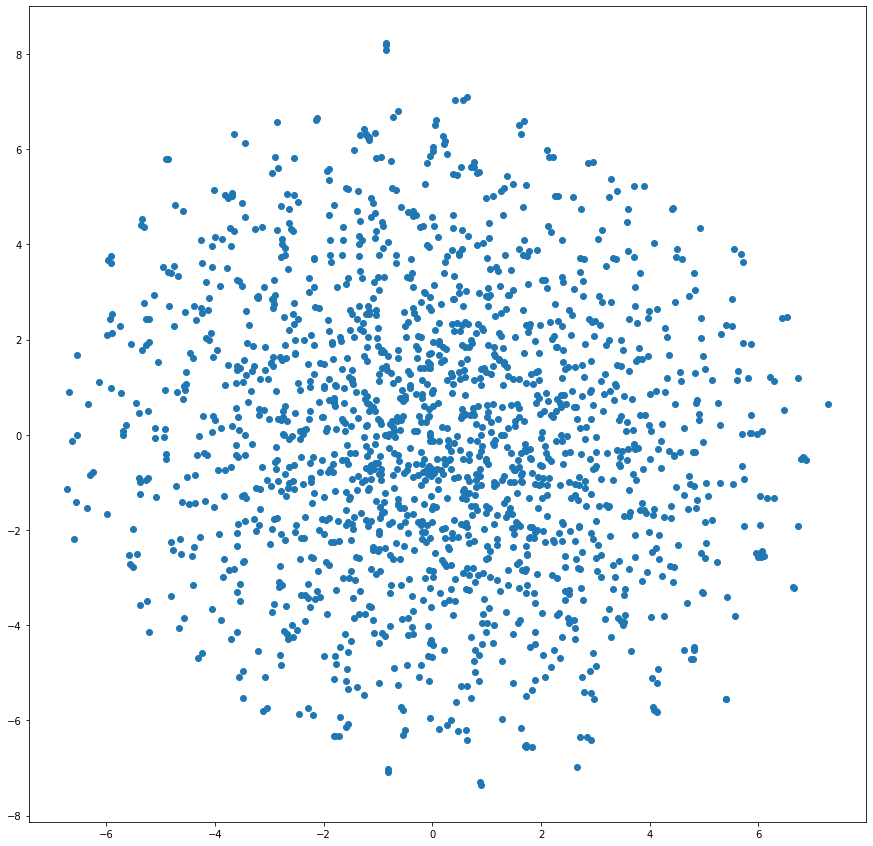

In [85]:
plt.figure(figsize=(15,15))
plt.scatter(item_factors_embedded[:, 0], item_factors_embedded[:, 1])

In [92]:
animation_colours = np.zeros(movie_titles.shape[0])
for row in movie_titles.itertuples():
    idx = trainset.to_inner_iid(str(row.movie_id))
    if row.Animation:
        animation_colours[idx] = 1

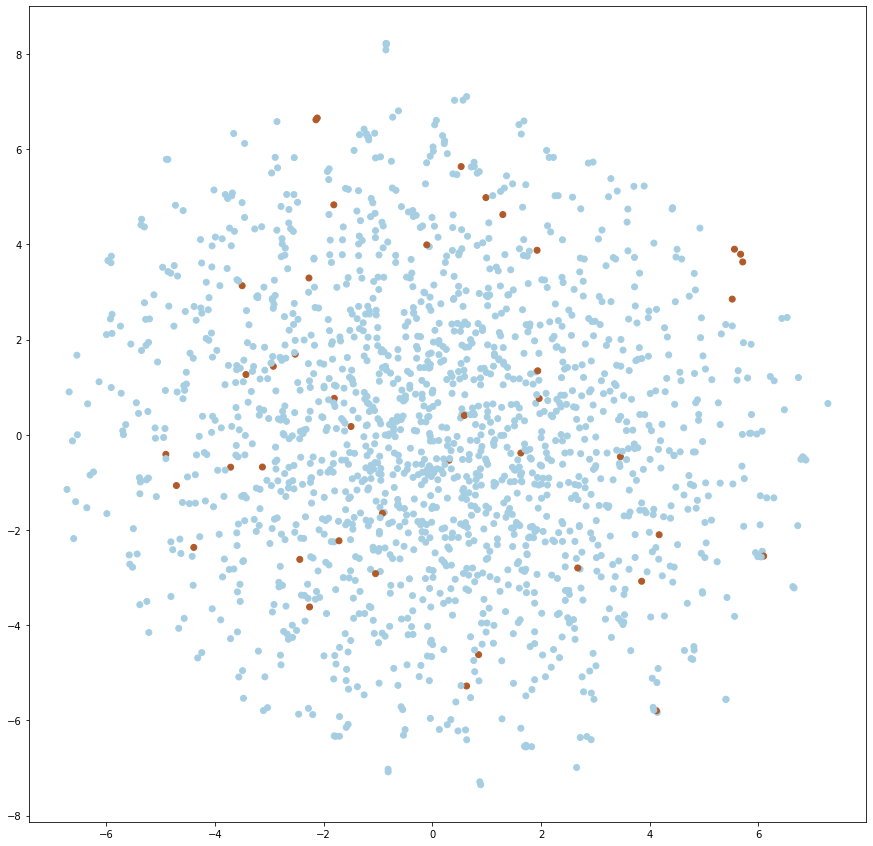

In [98]:
plt.figure(figsize=(15,15))
plt.scatter(item_factors_embedded[:, 0], item_factors_embedded[:, 1], c=animation_colours, cmap='Paired')

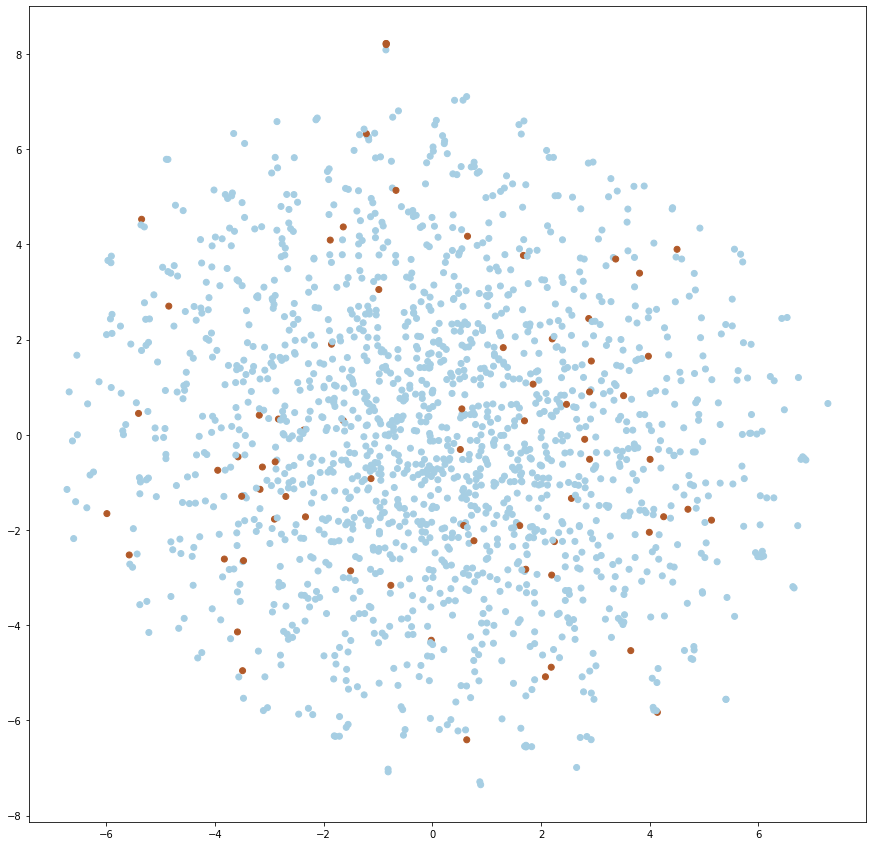

In [108]:
war_colours = np.zeros(movie_titles.shape[0])
for row in movie_titles.itertuples():
    idx = trainset.to_inner_iid(str(row.movie_id))
    if row.War:
        war_colours[idx] = 1
plt.figure(figsize=(15,15))
plt.scatter(item_factors_embedded[:, 0], item_factors_embedded[:, 1], c=war_colours, cmap='Paired')

In [99]:
movie_titles

,movie_id,movie_title,release_date,video_release_date,IMDbURL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
